In [1]:
import os

# Set datapath properly
path = os.getcwd() + "/data/"

if not os.path.exists(path):
  os.makedirs(path)

%env DATAPATH={path}

raw = 's.rsf'
raw_hfile = 's_hfile.rsf'
raw_tfile = 's_tfile.txt'
raw_bfile = 's_bfile.txt'
raw_deghost = "s_deghost.rsf"
raw_deghost_cdp = 's_deghost_cdp.rsf'
raw_deghost_gain = "s_deghost_gain.rsf"
raw_deghost_gain_cdp = "s_deghost_gain_cdp.rsf"
raw_deghost_gain_mute = "s_deghost_gain_mute.rsf"
raw_deghost_gain_mute_cdp = "s_deghost_gain_mute_cdp.rsf"
vnmo_rsf = 'vnmo.rsf'
vnmow_rsf = 'vnmow.rsf'
sample = 'sample.rsf'
sample_deghost = 'sample_deghost.rsf'
sample_deghost_gain = 'sample_deghost_gain.rsf'
header_complete = 'sp_header_complete.rsf'
header_complete_int = 'sp_header_complete_int.rsf'
offsets = 'offsets.rsf'
cdp_offsets = 'cdp_offsets.rsf'
sample_offsets = 'sample_cdp_offsets.rsf'
sample_cdp_offsets = 'sample_cdp_offsets.rsf'
cdp_mask = "cdp_mask.rsf"
wavelet_file = "FarField.dat"

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from rsf.proj import *
import rsf.api as sf
import m8r
from m8r import view
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import periodogram, welch
from wiggle.wiggle import wiggle
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

env: DATAPATH=/mnt/HDD_2TB/VikingGraben/line12/proc_rsf/data/


Extract SP and CDP sample

In [2]:
sample_deghost_gain_mute = 'sample_deghost_gain_mute.rsf'
sample_deghost_gain_mute_cdp = 'sample_deghost_gain_mute_cdp.rsf'

!sfwindow < {raw_deghost_gain_mute} n2=120 > {sample_deghost_gain_mute}

cdp = 1000
!sfwindow f3={cdp} n3=1 < {raw_deghost_gain_mute_cdp} > {sample_deghost_gain_mute_cdp}

Dip filter (SP)

sffft1: using 8 of 8 threads
sffft1: using 8 of 8 threads
sffft3: padded to 240


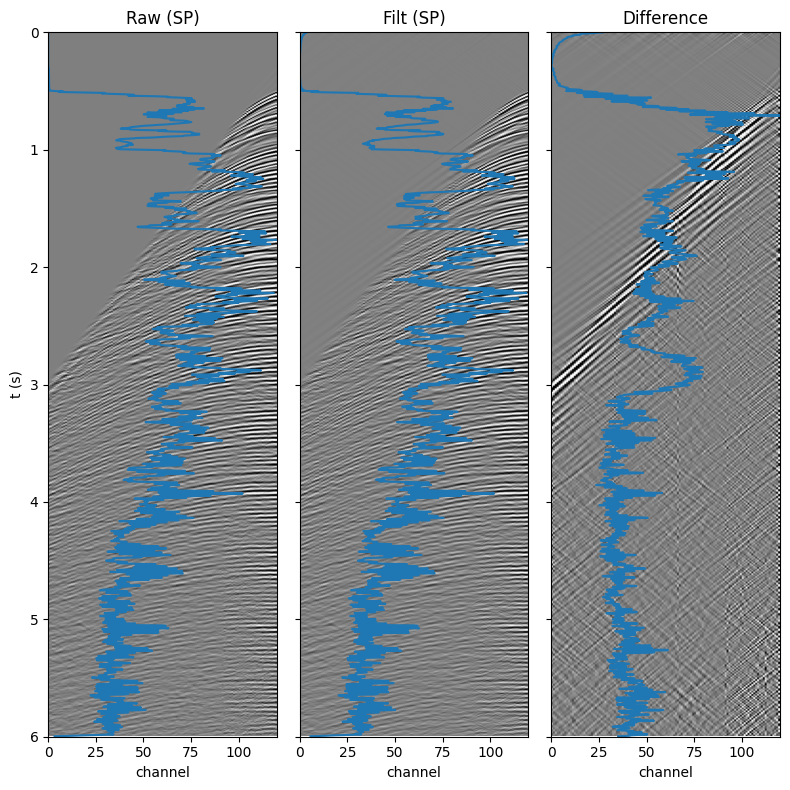

In [5]:
sample_deghost_gain_mute_dip = 'sample_deghost_gain_mute_dip.rsf'
raw = sample_deghost_gain_mute
proc = sample_deghost_gain_mute_dip

# process
v1 = -90
v2 = -83
v3 =  83
v4 =  90
!sffft1 < {raw} | sffft3 | \
    sfdipfilter v1={v1} v2={v2} v3={v3} v4={v4} pass=n | \
    sffft3 inv=y | sffft1 inv=y > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw (SP)", "Filt (SP)", "Difference"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    rms = np.sqrt(np.mean(data**2, axis=0))
    coef = data.shape[0]/(rms.max()-rms.min())
    rms_normilized = (rms-rms.min())*coef
    plt.plot(rms_normilized, t)
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Visualize FK Spectrums

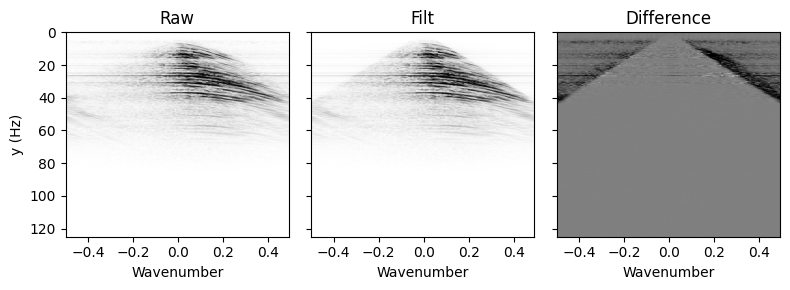

In [5]:
raw = "fft_raw.rsf"
proc = "fft_proc.rsf"

# process
!sfspectra2 < {sample_deghost_gain_mute} > {raw}
!sfspectra2 < {sample_deghost_gain_mute_dip} > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw)
o1 = raw_in.float('o1')
o2 = raw_in.float('o2')
d1 = raw_in.float('d1')
d2 = raw_in.float('d2')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

x = o2 + np.arange(raw_arr.shape[0]) * d2
y = o1 + np.arange(raw_arr.shape[1]) * d1

titles = ["Raw", "Filt", "Difference"]
plt.figure(figsize=(8,3))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [x[0], x[-1], y[-1], y[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('y (Hz)')
    plt.xlabel('Wavenumber')
    plt.title(titles[i])
    # plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Apply the processing to the whole dataset

In [19]:
raw_deghost_gain_mute_dip = "s_deghost_gain_mute_dip.rsf"
raw_deghost_gain_mute_dip_cdp = "s_deghost_gain_mute_dip_cdp.rsf"

raw = raw_deghost_gain_mute
proc = raw_deghost_gain_mute_dip
proc_cdp = raw_deghost_gain_mute_dip_cdp

t0=0
v0=1.1
!sffft1 < {raw} | sffft3 | \
    sfdipfilter v1={v1} v2={v2} v3={v3} v4={v4} pass=n | \
    sffft3 inv=y | sffft1 inv=y | \
    sfmutter offset={offsets} half=n t0={t0} v0={v0} > {proc}
!sfintbin < {proc} yk=cdp xk=cdpt head={header_complete_int} > {proc_cdp}

sffft1: using 8 of 8 threads
sffft1: using 8 of 8 threads
sffft3: padded to 243000
sfintbin: 2142 of 2142;


Check CDP (sometimes artefactes appear in CDP sorting)

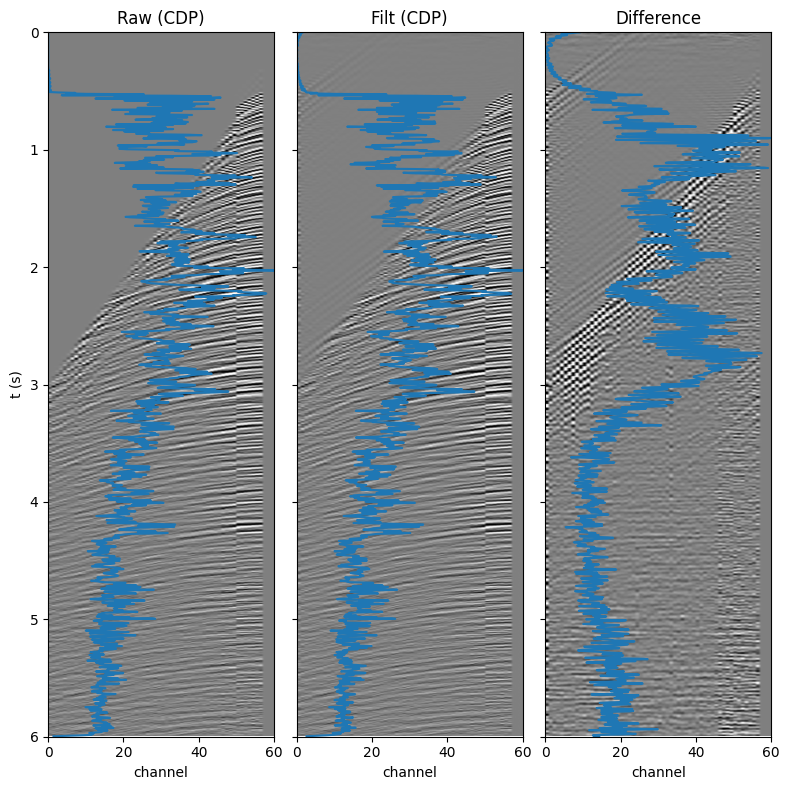

In [14]:
sample_deghost_gain_mute_dip_cdp = 'sample_deghost_gain_mute_dip_cdp.rsf'

raw = sample_deghost_gain_mute_cdp
proc = sample_deghost_gain_mute_dip_cdp

# process
cdp=1000
!sfwindow < {raw_deghost_gain_mute_cdp} f3={cdp} n3=1 > {raw}
!sfwindow < {raw_deghost_gain_mute_dip_cdp} f3={cdp} n3=1 > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw (CDP)", "Filt (CDP)", "Difference"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    rms = np.sqrt(np.mean(data**2, axis=0))
    coef = data.shape[0]/(rms.max()-rms.min())
    rms_normilized = (rms-rms.min())*coef
    plt.plot(rms_normilized, t)
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Compare stacks

sfnmo: CMP 2142 of 2142;
sfnmo: CMP 2142 of 2142;


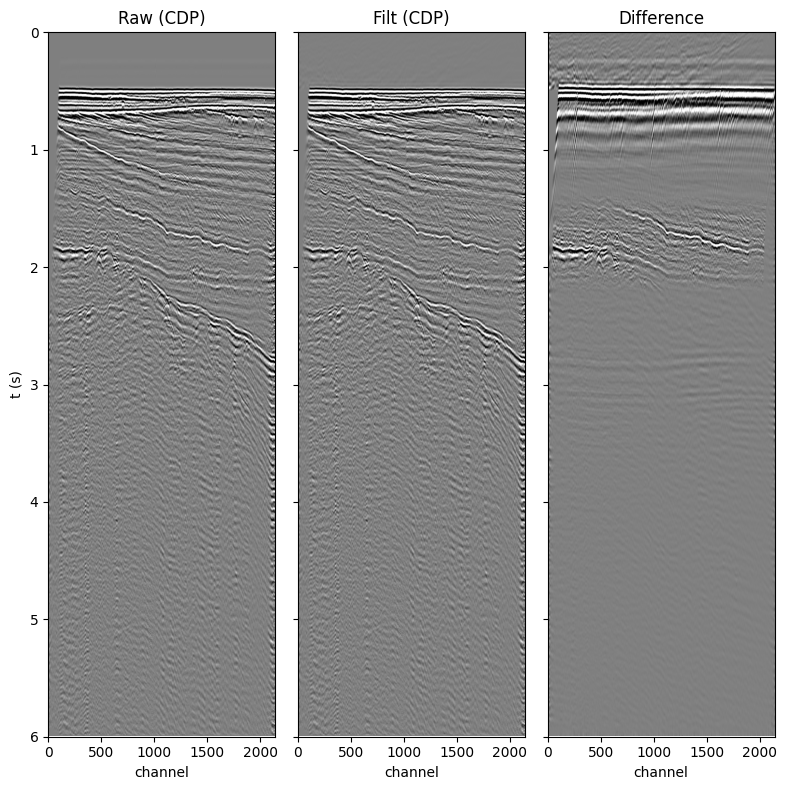

In [15]:
raw = raw_deghost_gain_mute_cdp
proc = raw_deghost_gain_mute_dip_cdp

raw_stack = 's_deghost_gain_mute_cdp_stk.rsf'
proc_stack = 's_deghost_gain_mute_dip_cdp_stk.rsf'

!sfnmo < {raw} velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
    sfstack > {raw_stack}

!sfnmo < {proc} velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
    sfstack > {proc_stack}

# Load stacks and visualize it
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

plt.figure(figsize=(8, 8))
for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)